In [2]:
from google.colab import files
uploaded = files.upload()

Saving customer_shopping_data.csv to customer_shopping_data (1).csv


In [ ]:
# ============================================
# Mini Project: Multi-class Classification (+ Tuning)
# Dataset: customer_shopping_data.csv
# Target: category (fallback: product_category)
# Models: KNN, Decision Tree, Random Forest
# Metrics: Accuracy + Confusion Matrix
# Tuning: GridSearchCV (KNN k, DT max_depth, RF n_estimators/max_features)
# Plots: ใช้โทนสีอ่านง่าย (Blues/Greens/Purples) + bar สีไล่เฉด
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# Plot styling (อ่านง่าย)
# -----------------------------
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = False

CMAP_MAP = {
    "KNN": plt.cm.Blues,
    "Decision Tree": plt.cm.Greens,
    "Random Forest": plt.cm.Purples,
    "Tuned KNN": plt.cm.Blues,
    "Tuned Decision Tree": plt.cm.Greens,
    "Tuned Random Forest": plt.cm.Purples,
}

def plot_confusion(y_true, y_pred, labels_all, title, cmap):
    cm = confusion_matrix(y_true, y_pred, labels=labels_all)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
    fig, ax = plt.subplots(figsize=(7.5, 6.2))
    disp.plot(ax=ax, values_format="d", cmap=cmap, colorbar=True)
    ax.set_title(title, fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_feature_importance(fi_df, title="Feature Importances (Top 20)"):
    top20 = fi_df.head(20).iloc[::-1]
    norm = mpl.colors.Normalize(vmin=top20["importance"].min(), vmax=top20["importance"].max())
    colors = plt.cm.Blues(norm(top20["importance"].values))

    plt.figure(figsize=(10, 7))
    plt.barh(top20["feature"], top20["importance"], color=colors)
    plt.title(title, fontsize=14)
    plt.xlabel("Importance")
    plt.grid(axis="x", linestyle="--", alpha=0.25)
    plt.tight_layout()
    plt.show()

In [4]:
df = pd.read_csv("customer_shopping_data.csv")

# -----------------------------
# 1) Set TARGET automatically: category / product_category
# -----------------------------
TARGET_CANDIDATES = ["category", "product_category"]
TARGET_COL = next((c for c in TARGET_CANDIDATES if c in df.columns), None)

if TARGET_COL is None:
    raise ValueError(f" Cannot find target column in {TARGET_CANDIDATES}. Available columns: {list(df.columns)}")

print("\n TARGET_COL =", TARGET_COL)


 TARGET_COL = category


In [5]:
# -----------------------------
# 2) Basic cleaning + date feature engineering
# -----------------------------
if "invoice_date" in df.columns:
    df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")
    df["invoice_year"] = df["invoice_date"].dt.year
    df["invoice_month"] = df["invoice_date"].dt.month
    df["invoice_day"] = df["invoice_date"].dt.day
    df["invoice_dayofweek"] = df["invoice_date"].dt.dayofweek
    df = df.drop(columns=["invoice_date"])

# แนะนำ drop คอลัมน์รหัส/เลขอ้างอิง เพื่อลดการ “จำเลข”
DROP_COLS = ["invoice_no", "customer_id"]
drop_exist = [c for c in DROP_COLS if c in df.columns]

X = df.drop(columns=[TARGET_COL] + drop_exist)
y = df[TARGET_COL]

print("\nDropped columns:", drop_exist)
print("X shape:", X.shape, " | #classes:", y.nunique())
print("\nTarget distribution:")
display(y.value_counts())


Dropped columns: ['invoice_no', 'customer_id']
X shape: (99457, 10)  | #classes: 8

Target distribution:


,count
category,
Clothing,34487
Cosmetics,15097
Food & Beverage,14776
Toys,10087
Shoes,10034
Souvenir,4999
Technology,4996
Books,4981


In [6]:
# -----------------------------
# 3) Train/Test split (stratify ถ้าทำได้)
# -----------------------------
stratify_y = y if y.nunique() > 1 and y.value_counts().min() >= 2 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_y
)

labels_all = np.unique(y)
# -----------------------------
# 4) Preprocessing: numeric + categorical
# -----------------------------
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # สำคัญกับ KNN
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


Numeric features: ['age', 'quantity', 'price', 'invoice_year', 'invoice_month', 'invoice_day', 'invoice_dayofweek']
Categorical features: ['gender', 'payment_method', 'shopping_mall']



================ BASELINE KNN ================
Test Accuracy: 0.6090388095716871


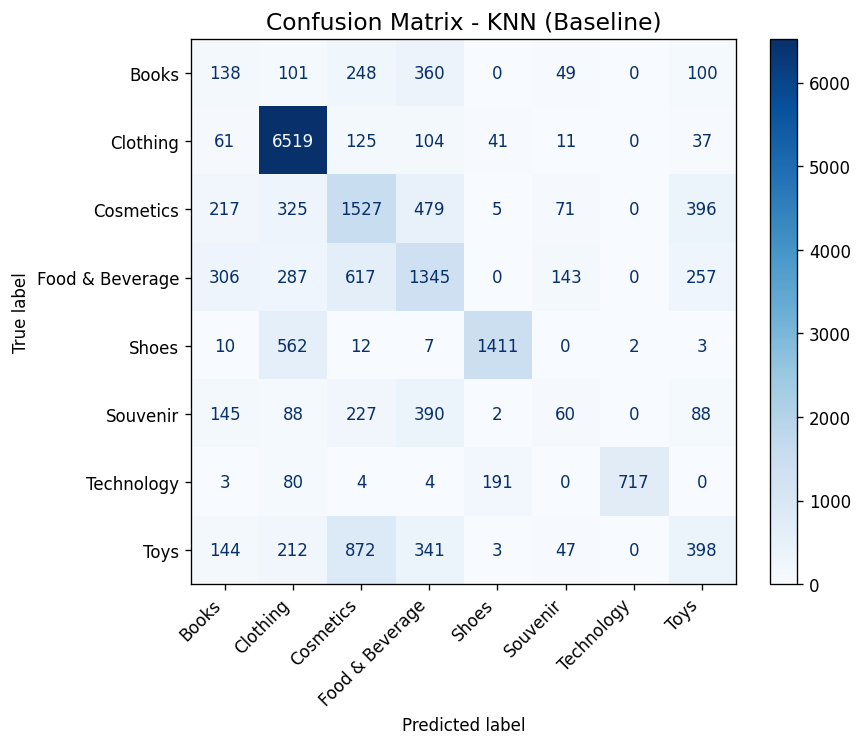


================ BASELINE Decision Tree ================
Test Accuracy: 1.0


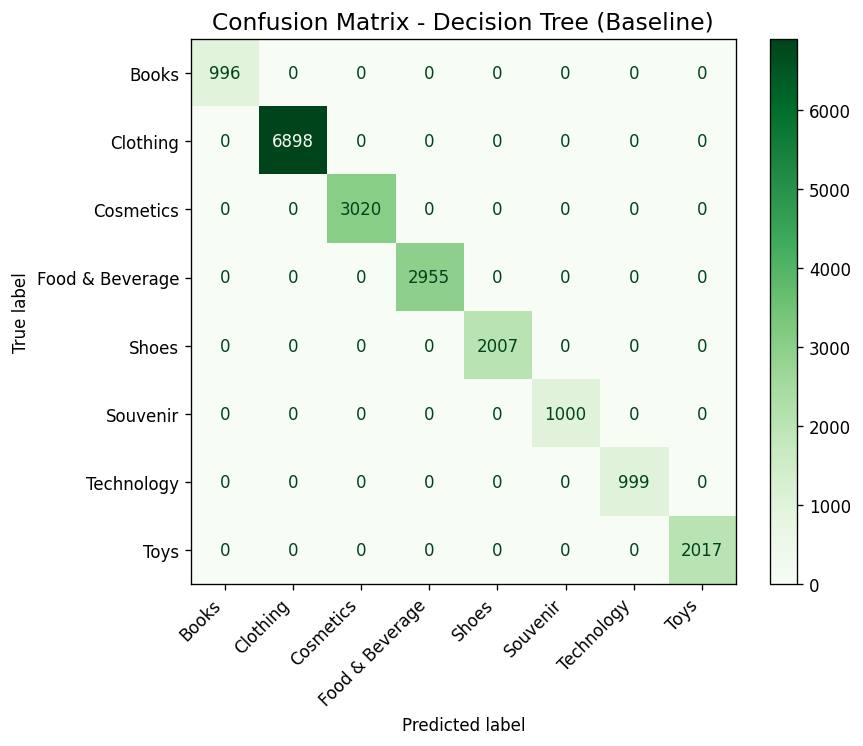


================ BASELINE Random Forest ================
Test Accuracy: 0.9938166096923386


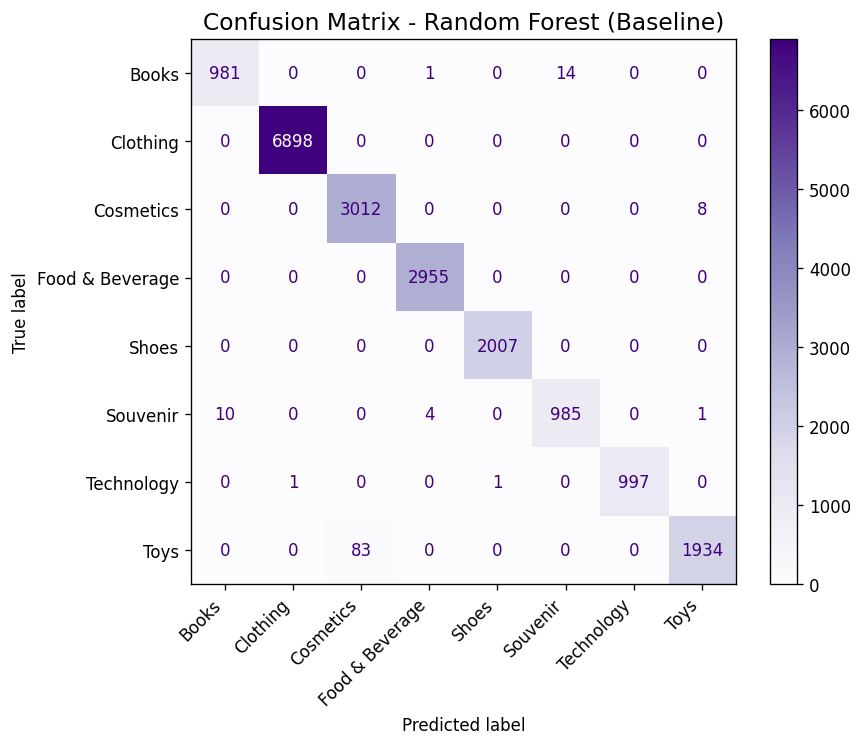


 Baseline Model Comparison (sorted by Accuracy)


,Model,Accuracy
0,Decision Tree,1.000000
1,Random Forest,0.993817
2,KNN,0.609039


In [7]:
# -----------------------------
# 5) Baseline training: KNN / DT / RF
# -----------------------------
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
}

baseline_results = []
baseline_pipes = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clf)])
    pipe.fit(X_train, y_train)
    baseline_pipes[name] = pipe

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    baseline_results.append({"Model": name, "Accuracy": acc})

    print(f"\n================ BASELINE {name} ================")
    print("Test Accuracy:", acc)

    plot_confusion(
        y_true=y_test,
        y_pred=y_pred,
        labels_all=labels_all,
        title=f"Confusion Matrix - {name} (Baseline)",
        cmap=CMAP_MAP.get(name, plt.cm.Blues),
    )

baseline_df = pd.DataFrame(baseline_results).sort_values("Accuracy", ascending=False).reset_index(drop=True)
print("\n Baseline Model Comparison (sorted by Accuracy)")
display(baseline_df)


================ TUNED KNN ================
Best CV score (mean): 0.6232639979890656
Best params: {'model__n_neighbors': 9, 'model__weights': 'distance'}
Test Accuracy: 0.6415644480193042


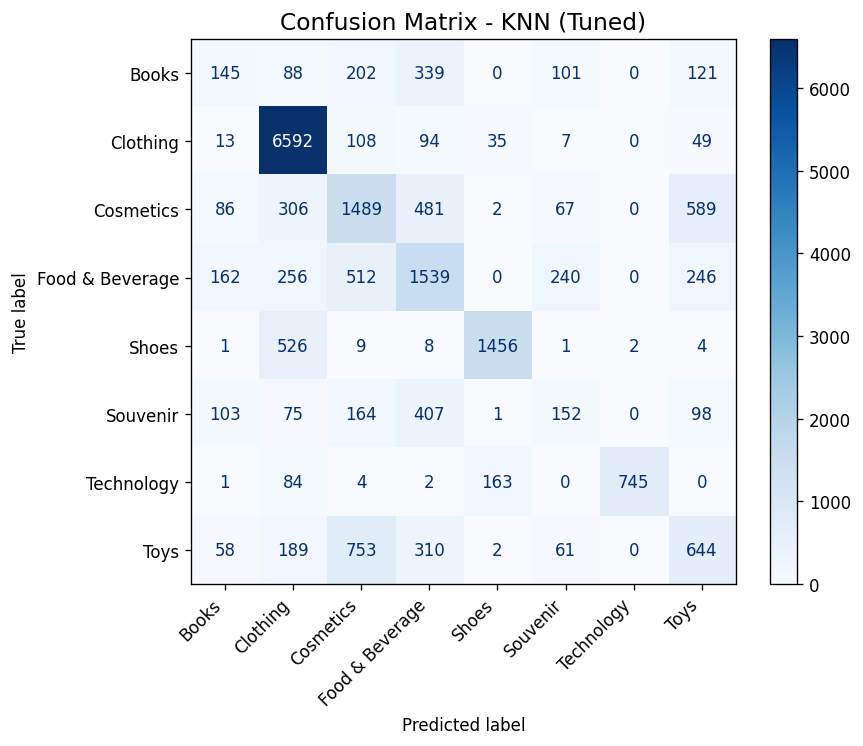


================ TUNED Decision Tree ================
Best CV score (mean): 1.0
Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1}
Test Accuracy: 1.0


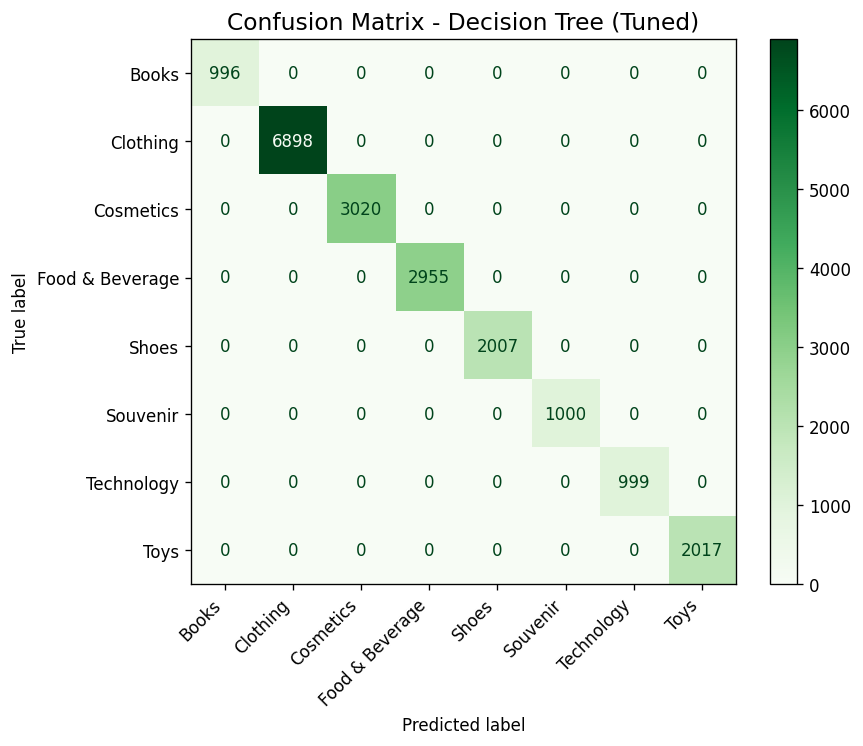

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# -----------------------------
# 6) Tuning (GridSearchCV)
# -----------------------------
def tune_model(name, model, param_grid, cv=5):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)

    best_pipe = gs.best_estimator_
    y_pred = best_pipe.predict(X_test)

    acc_test = accuracy_score(y_test, y_pred)

    print(f"\n================ TUNED {name} ================")
    print("Best CV score (mean):", gs.best_score_)
    print("Best params:", gs.best_params_)
    print("Test Accuracy:", acc_test)

    plot_confusion(
        y_true=y_test,
        y_pred=y_pred,
        labels_all=labels_all,
        title=f"Confusion Matrix - {name} (Tuned)",
        cmap=CMAP_MAP.get(f"Tuned {name}", plt.cm.Blues),
    )

    return {
        "Model": f"Tuned {name}",
        "BestParams": gs.best_params_,
        "CV_BestScore": gs.best_score_,
        "TestAccuracy": acc_test,
        "BestEstimator": best_pipe
    }

# KNN: จูน k + weights
tuned_knn = tune_model(
    name="KNN",
    model=KNeighborsClassifier(),
    param_grid={
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"]
    },
    cv=5
)

# Decision Tree: จูน max_depth + min_samples_leaf
tuned_dt = tune_model(
    name="Decision Tree",
    model=DecisionTreeClassifier(random_state=42),
    param_grid={
        "model__max_depth": [None, 3, 5, 7, 10, 15],
        "model__min_samples_leaf": [1, 2, 5]
    },
    cv=5
)

# Random Forest: จูน n_estimators + max_features + max_depth
tuned_rf = tune_model(
    name="Random Forest",
    model=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid={
        "model__n_estimators": [100, 300, 500],
        "model__max_features": ["sqrt", "log2", None],
        "model__max_depth": [None, 10, 20]
    },
    cv=5
)

tuned_df = pd.DataFrame([
    {k: v for k, v in tuned_knn.items() if k != "BestEstimator"},
    {k: v for k, v in tuned_dt.items() if k != "BestEstimator"},
    {k: v for k, v in tuned_rf.items() if k != "BestEstimator"},
]).sort_values("TestAccuracy", ascending=False).reset_index(drop=True)

print("\n Tuned Model Comparison (sorted by TestAccuracy)")
display(tuned_df)

best_tuned_model_name = tuned_df.loc[0, "Model"]
print("\n Best tuned model:", best_tuned_model_name)

best_pipe_map = {
    "Tuned KNN": tuned_knn["BestEstimator"],
    "Tuned Decision Tree": tuned_dt["BestEstimator"],
    "Tuned Random Forest": tuned_rf["BestEstimator"],
}
best_tuned_pipe = best_pipe_map[best_tuned_model_name]

In [ ]:
# -----------------------------
# 7) Feature Importance (เฉพาะ RF tuned/baseline ที่ได้)
# -----------------------------
def get_feature_names_from_preprocess(preprocess_fitted, numeric_features, categorical_features):
    feature_names = []
    feature_names.extend(numeric_features)
    if len(categorical_features) > 0:
        ohe = preprocess_fitted.named_transformers_["cat"].named_steps["onehot"]
        feature_names.extend(ohe.get_feature_names_out(categorical_features).tolist())
    return feature_names

# ถ้า best tuned เป็น RF ให้ทำ FI ของ best tuned เลย
if best_tuned_model_name == "Tuned Random Forest":
    rf_model = best_tuned_pipe.named_steps["model"]
    prep_fitted = best_tuned_pipe.named_steps["preprocess"]

    feature_names = get_feature_names_from_preprocess(prep_fitted, numeric_features, categorical_features)
    fi = pd.DataFrame({"feature": feature_names, "importance": rf_model.feature_importances_}).sort_values(
        "importance", ascending=False
    )

    print("\n Top 20 Feature Importances (Best Tuned Random Forest)")
    display(fi.head(20))
    plot_feature_importance(fi, title="Best Tuned Random Forest - Top 20 Feature Importances")

# ถ้า best tuned ไม่ใช่ RF แต่ยังอยากโชว์ FI ของ RF tuned ก็แสดงให้ด้วย
else:
    print("\n Best tuned model is not Random Forest.")
    print("Showing Feature Importances for Tuned Random Forest (for discussion).")

    rf_pipe = tuned_rf["BestEstimator"]
    rf_model = rf_pipe.named_steps["model"]
    prep_fitted = rf_pipe.named_steps["preprocess"]

    feature_names = get_feature_names_from_preprocess(prep_fitted, numeric_features, categorical_features)
    fi = pd.DataFrame({"feature": feature_names, "importance": rf_model.feature_importances_}).sort_values(
        "importance", ascending=False
    )

    print("\n Top 20 Feature Importances (Tuned Random Forest)")
    display(fi.head(20))
    plot_feature_importance(fi, title="Tuned Random Forest - Top 20 Feature Importances")

In [ ]:
# -----------------------------
# 8) (Optional) Save outputs
# -----------------------------
# baseline_df.to_csv("baseline_model_comparison.csv", index=False)
# tuned_df.to_csv("tuned_model_comparison.csv", index=False)
# fi.head(50).to_csv("rf_feature_importance_top50.csv", index=False)